# Using FBProhphet to forecast stock price

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import ipywidgets as widgets
import requests
import random
import time
import matplotlib.dates as mdates
import itertools

# Importing encoders
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Import for string manipulation
import nltk
import string
import re


# Time Series Imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from prophet import Prophet

# Model Evaluation Imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# To increase the visible rows & cols
pd.options.display.max_rows = 2500
pd.options.display.max_columns = 15000

### Data Import: Importing stocks data that we will be predicting

These are the stocks that we will be forecasting:

r/wallstreetbets:
1. GME
2. AMC
3. TSLA
4. META

r/investing:
1. GM
2. UBER
3. RIOT
4. AMD

In [56]:
# import the 10 year historical data of each stock

# r/wallstreetbets
gme_test_df = pd.read_csv('../data/gme1_historical.csv')
gme_yahoo_df = pd.read_csv('../data/gme_historical_yahoo.csv')
gme_df = pd.read_csv('../data/gme_historical.csv')
amc_df = pd.read_csv('../data/amc_historical.csv')
tsla_df = pd.read_csv('../data/tsla_historical.csv')
meta_df = pd.read_csv('../data/meta_historical.csv')

# r/investing
gm_df = pd.read_csv('../data/gm_historical.csv')
uber_df = pd.read_csv('../data/uber_historical.csv')
riot_df = pd.read_csv('../data/riot_historical.csv')
amd_df = pd.read_csv('../data/amd_historical.csv')

In [57]:
# Comment seems like there are $ signs in the data  which we will need to remove later on

gme_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,07/25/2023,$22.85,1671991,$23.10,$23.10,$22.53
1,07/24/2023,$23.04,2970433,$22.42,$23.04,$22.20
2,07/21/2023,$22.18,3167916,$23.05,$23.22,$22.16
3,07/20/2023,$22.91,2256659,$23.01,$23.22,$22.66
4,07/19/2023,$23.17,2250133,$23.42,$23.58,$22.96


In [58]:
# Comment: There seems to be no null values here

gme_df.isnull().sum().sort_values(ascending = False)

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [59]:
# Doesnt seem to have any duplicated data either

print(gme_df[gme_df.duplicated()])

Empty DataFrame
Columns: [Date, Close/Last, Volume, Open, High, Low]
Index: []


In [60]:
# Will need to change the data type for price columns into float

gme_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [61]:
# To remove the $ sign and change the datatypes into float

def clean_data(df):
    for col in ["Close/Last", "Open", "High", "Low"]:
        df[col] = df[col].str.replace("$", "").astype(float)

In [62]:
clean_data(gme_test_df)
gme_test_df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)


,Date,Close/Last,Volume,Open,High,Low
0,07/25/2023,22.85,1671991,23.10,23.10,22.53
1,07/24/2023,23.04,2970433,22.42,23.04,22.20
2,07/21/2023,22.18,3167916,23.05,23.22,22.16
3,07/20/2023,22.91,2256659,23.01,23.22,22.66
4,07/19/2023,23.17,2250133,23.42,23.58,22.96


For the purpose of price prediction, we will use VWAP as the price of stock

VWAP is defined as: Volume Weighted Average Price, it is a trading benchmark that represents the average price a security traded at throughout the day, based on both volume and price.

- VWAP = (Cumulative typical price * Volume) / Culmulative Volume
- Where: Typical Price = (High Price + Low Price + Closing Price)/3

In [63]:
# Create a function that adds a new column "VWAP" to the dataframe

def calc_vwap(df):
    df["Typical_Price"] = (df["High"] + df["Low"] + df["Close/Last"])/3
    df["VWAP"] = (np.cumsum(df["Volume"] * df["Typical_Price"]) / np.cumsum(df["Volume"])).round(2)
    return df


In [64]:
# Generate VWAP which will be the price we will use in the time series prediction

calc_vwap(gme_test_df)

,Date,Close/Last,Volume,Open,High,Low,Typical_Price,VWAP
0,07/25/2023,22.8500,1671991,23.1000,23.1000,22.5300,22.826667,22.83
1,07/24/2023,23.0400,2970433,22.4200,23.0400,22.2000,22.760000,22.78
2,07/21/2023,22.1800,3167916,23.0500,23.2200,22.1600,22.520000,22.68
3,07/20/2023,22.9100,2256659,23.0100,23.2200,22.6600,22.930000,22.73
4,07/19/2023,23.1700,2250133,23.4200,23.5800,22.9600,23.236667,22.83
...,...,...,...,...,...,...,...,...
2511,08/01/2013,12.4950,16796516,12.3800,12.8400,12.3150,12.550000,16.17
2512,07/31/2013,12.2650,18825016,11.7850,12.3800,11.7850,12.143333,16.17
2513,07/30/2013,11.7275,10822960,11.3625,11.8125,11.3600,11.633333,16.17
2514,07/29/2013,11.3475,7770952,11.4175,11.4350,11.1425,11.308333,16.17


In [65]:
# Make a function that ensures that 'Date' is in datatime format
gme_test_df['Date'] = pd.to_datetime(gme_test_df['Date'])

# Set Date as the index for
gme_test_df.set_index("Date", inplace = True)

# Reset the order of the date so that it is from oldest to most recent to help the model to predict 
gme_test_df = gme_test_df.sort_index(ascending=True)

# From now we will only use VWAP to predict the price of the stock, so we shall remove other unnecessary columns
gme_test_df = gme_test_df[['VWAP']]

# Resets any prevailing indexes of the DataFrame, and use the default one instead
gme_test_df = gme_test_df.reset_index()

In [66]:
# Comment: looks like a good time series ready to be used for modelling

gme_test_df.head()

,Date,VWAP
0,2013-07-26,16.17
1,2013-07-29,16.17
2,2013-07-30,16.17
3,2013-07-31,16.17
4,2013-08-01,16.17


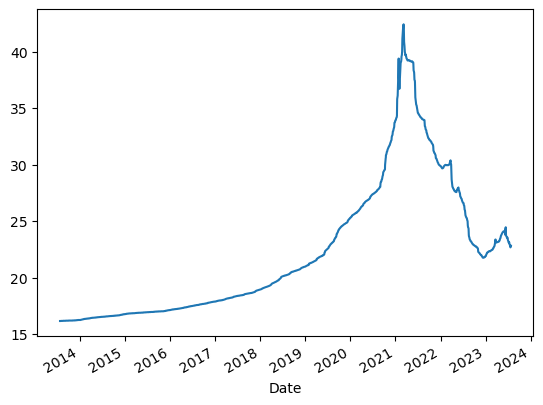

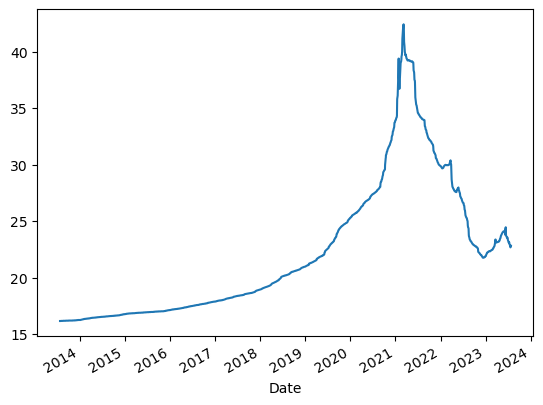

In [67]:
# gme_df['VWAP'].plot().get_figure()
gme_test_df.set_index('Date').VWAP.plot()

### Building FBProphet Model

12:50:59 - cmdstanpy - INFO - Chain [1] start processing
12:51:00 - cmdstanpy - INFO - Chain [1] done processing


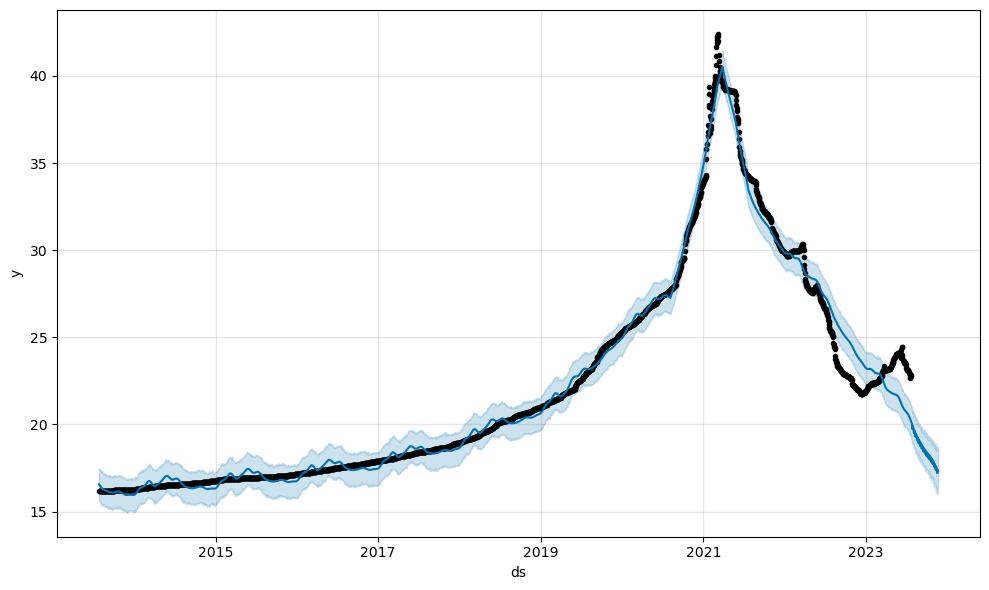

In [68]:
# Create a new DataFrame with which we will create/train our Prophet model 
df = pd.DataFrame()
df['ds'] = gme_test_df['Date']
df['y'] = gme_test_df['VWAP']

# Initialize the Model
model=Prophet()

# Fit the Model
model.fit(df)

# Create an object that specifies the desired number of periods to forecast
future = model.make_future_dataframe(periods=120)

# Generate a forecast
forecast = model.predict(future)

# Plot the resulting forecast
model.plot(forecast)
plt.show()

In [69]:
# Making forecast for the period of next 24 months

future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
2535,2025-02-28
2536,2025-03-31
2537,2025-04-30
2538,2025-05-31
2539,2025-06-30


In [70]:
forecast = model.predict(future)

In [71]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2535,2025-02-28,9.680963,-2.830802,21.495486
2536,2025-03-31,8.886899,-4.684475,22.049933
2537,2025-04-30,8.539605,-6.066829,22.297302
2538,2025-05-31,8.042386,-7.757436,22.926446
2539,2025-06-30,7.506395,-9.330544,23.723372


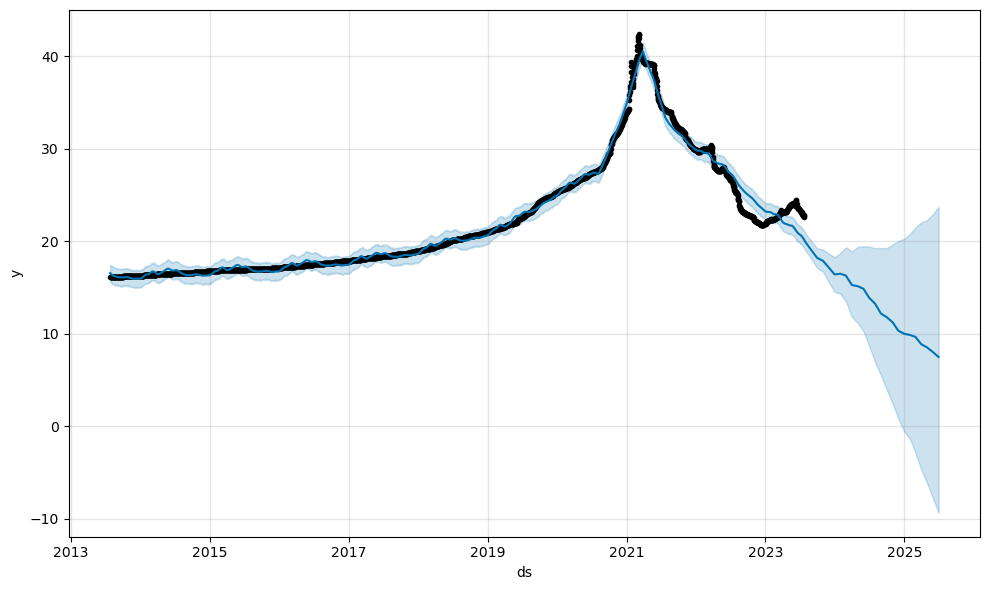

In [72]:
model.plot(forecast);

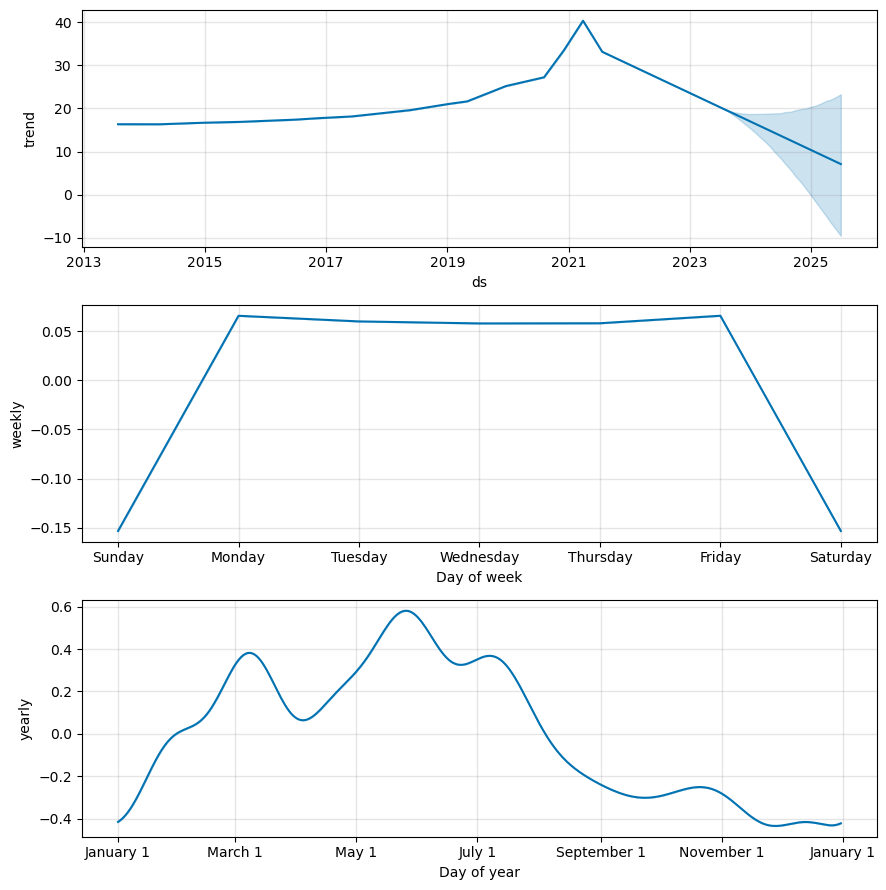

In [73]:
# decompose time series model into trend and seasonality
model.plot_components(forecast);

### Model Evaluation

In [74]:
# add forecasted data to existing data set / data frame
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [75]:
# optional - quick check on the future dates where the actual values are not available
metric_df.tail()

,ds,yhat,y
2535,2025-02-28,9.680963,NaN
2536,2025-03-31,8.886899,NaN
2537,2025-04-30,8.539605,NaN
2538,2025-05-31,8.042386,NaN
2539,2025-06-30,7.506395,NaN


In [76]:
# drop the rows of future dates where the actual values are not available
metric_df.dropna(inplace=True)

In [77]:
# optional - confirm if the rows of future dates have been dropped
metric_df.tail()

,ds,yhat,y
2511,2023-07-19,20.337716,22.83
2512,2023-07-20,20.305054,22.73
2513,2023-07-21,20.278981,22.68
2514,2023-07-24,20.173767,22.78
2515,2023-07-25,20.132033,22.83


In [78]:
rsquared = r2_score(metric_df.y, metric_df.yhat)
print('R-Squared: %.3f' % rsquared)

R-Squared: 0.986


In [79]:
mape = np.mean(np.abs((metric_df.y - metric_df.yhat)/metric_df.y))*100
print('MAPE: %.3f' % mape)

MAPE: 2.011


# Making a stock_forecast function to re-apply the previous steps thus far onto other stock's data 

In [80]:
def stock_forecast(df, stock_symbol, periods, freq):
    # Cleaning the data
    clean_data(df)
    
    # Calculate the VWAP
    df = calc_vwap(df)

    # Ensuring 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Set 'Date' as the index 
    df.set_index("Date", inplace = True)

    # Reset the order of the date 
    df = df.sort_index(ascending=True)

    # Removing unnecessary columns
    df = df[['VWAP']]

    # Resets the indexes of the DataFrame
    df = df.reset_index()

    # Create a new DataFrame for the Prophet model
    prophet_df = pd.DataFrame()
    prophet_df['ds'] = df['Date']
    prophet_df['y'] = df['VWAP']

    # Initialize the Model
    model=Prophet()

    # Fit the Model
    model.fit(prophet_df)

    # # Create an object that specifies the desired number of periods to forecast
    # future = model.make_future_dataframe(periods=120)

    # # Generate a forecast
    # forecast = model.predict(future)

    # Plot the resulting forecast
    # model.plot(forecast)
    # plt.show()

    future = model.make_future_dataframe(periods= periods, freq = freq)

    forecast = model.predict(future)

    # model.plot(forecast)
    # plt.title(f'{stock_symbol} VWAP Monthly Forecast')
    # plt.xlabel('Date')
    # plt.ylabel('VWAP')
    # plt.legend(['Actual', 'Predicted'])
    # plt.text(forecast.ds.min(), forecast.yhat.min(), 'R-Squared: %.3f' % rsquared, fontsize=12)
    # plt.text(forecast.ds.min(), forecast.yhat.min() - 10, 'MAPE: %.3f' % mape, fontsize=12)
    # plt.show()
   
    # model.plot_components(forecast)

    # add forecasted data to existing data set / data frame
    metric_df = forecast.set_index('ds')[['yhat']].join(prophet_df.set_index('ds').y).reset_index()

    # drop the rows of future dates where the actual values are not available
    metric_df.dropna(inplace=True)

    rsquared = r2_score(metric_df.y, metric_df.yhat)
    print('R-Squared: %.3f' % rsquared)

    mape = np.mean(np.abs((metric_df.y - metric_df.yhat)/metric_df.y))*100
    print('MAPE: %.3f%%' % mape)

    model.plot(forecast)
    plt.title(f'{stock_symbol} VWAP Monthly Forecast')
    plt.xlabel('Date')
    plt.ylabel('VWAP')
    plt.legend(['Actual', 'Predicted'])
    # plt.text(forecast.ds.min(), forecast.yhat.min() - 1, 'R-Squared: %.3f' % rsquared, fontsize=12)
    # plt.text(forecast.ds.min(), forecast.yhat.min() - 2, 'MAPE: %.3f%%' % mape, fontsize=12)
    x_loc = forecast.ds.max()
    y_loc_r2 = forecast.yhat.min() + (forecast.yhat.max() - forecast.yhat.min()) * 0.09
    y_loc_mape = forecast.yhat.min() + (forecast.yhat.max() - forecast.yhat.min()) * 0.2
    plt.text(x_loc, y_loc_r2, 'R-Squared: %.3f' % rsquared, fontsize=12, horizontalalignment='right')
    plt.text(x_loc, y_loc_mape, 'MAPE: %.3f%%' % mape, fontsize=12, horizontalalignment='right')
    plt.show()
   
    model.plot_components(forecast)
    plt.suptitle(f'{stock_symbol} forecast time series trend and seasonality decomposition')
    plt.subplots_adjust(top = 0.95)

## r/wallstreetbets stocks

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)
12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing


R-Squared: 0.986
MAPE: 2.011%


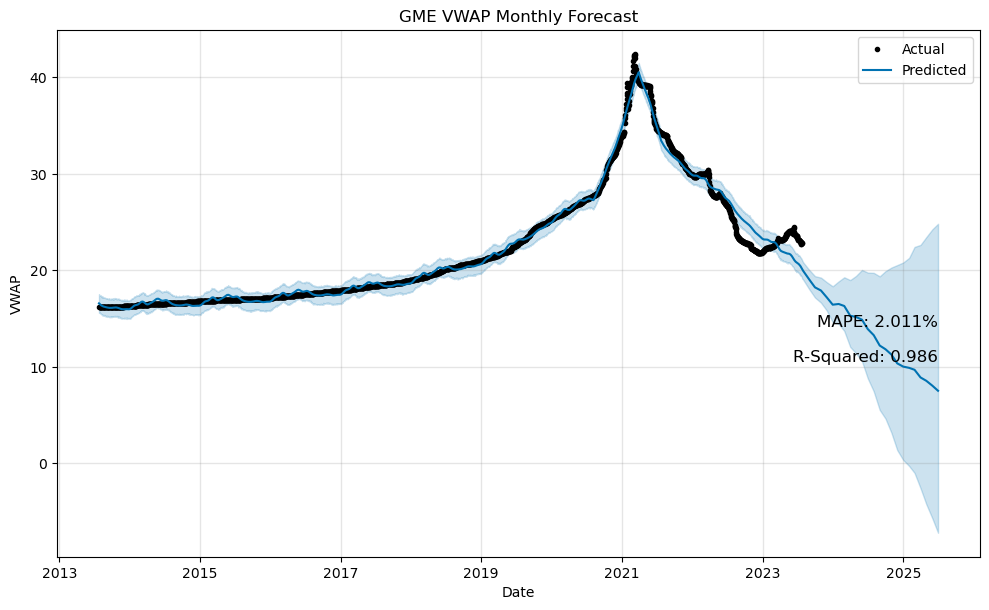

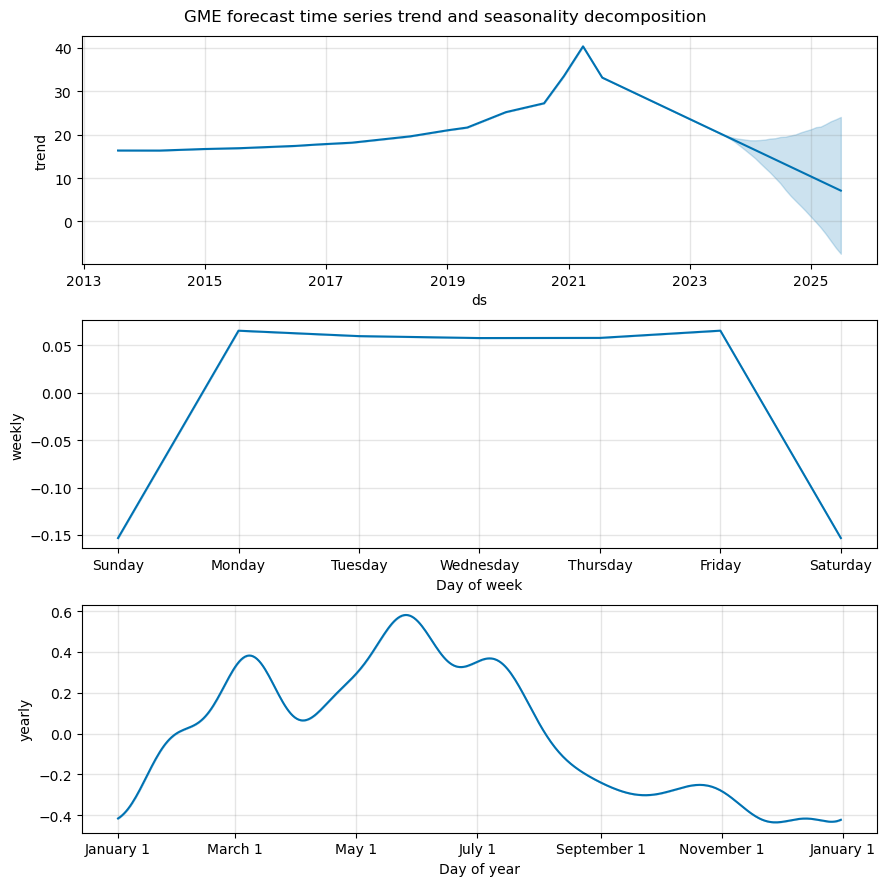

In [81]:
# Forecasting for stock price of GME

stock_forecast(gme_df, stock_symbol="GME", periods = 24, freq = 'm')

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)
12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:04 - cmdstanpy - INFO - Chain [1] done processing


R-Squared: 0.986
MAPE: 2.363%


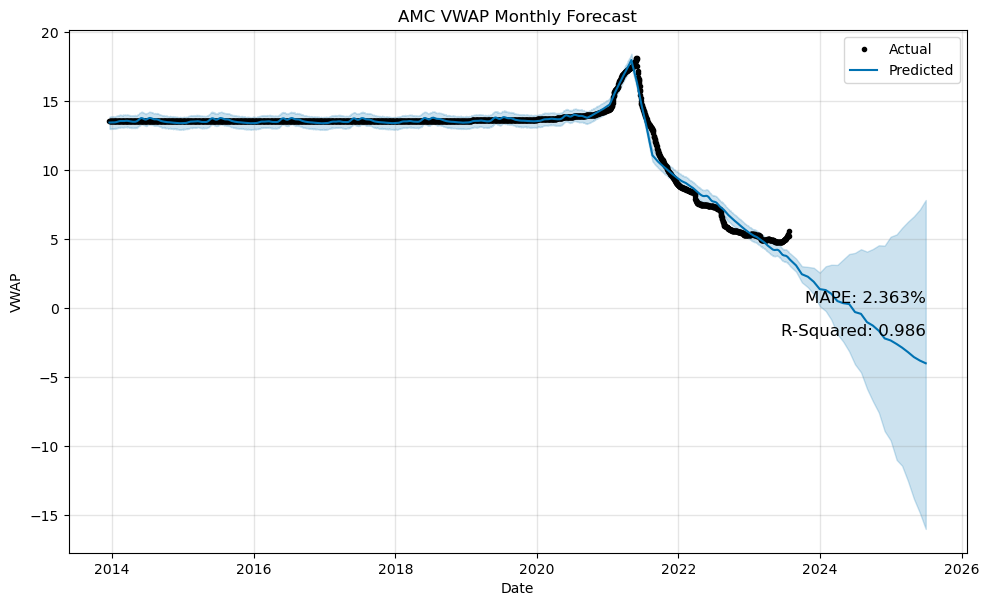

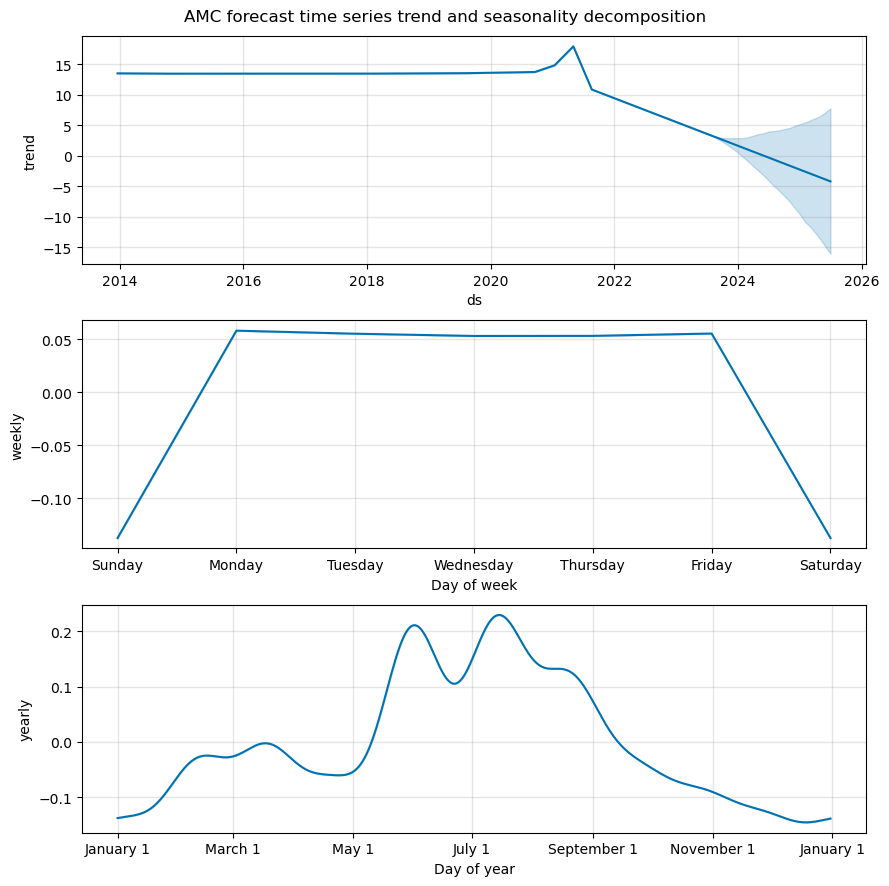

In [82]:
# Forecasting for stock price of AMC

stock_forecast(amc_df, stock_symbol="AMC", periods = 24, freq = 'm')

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)
12:51:06 - cmdstanpy - INFO - Chain [1] start processing
12:51:06 - cmdstanpy - INFO - Chain [1] done processing


R-Squared: 0.972
MAPE: 2.906%


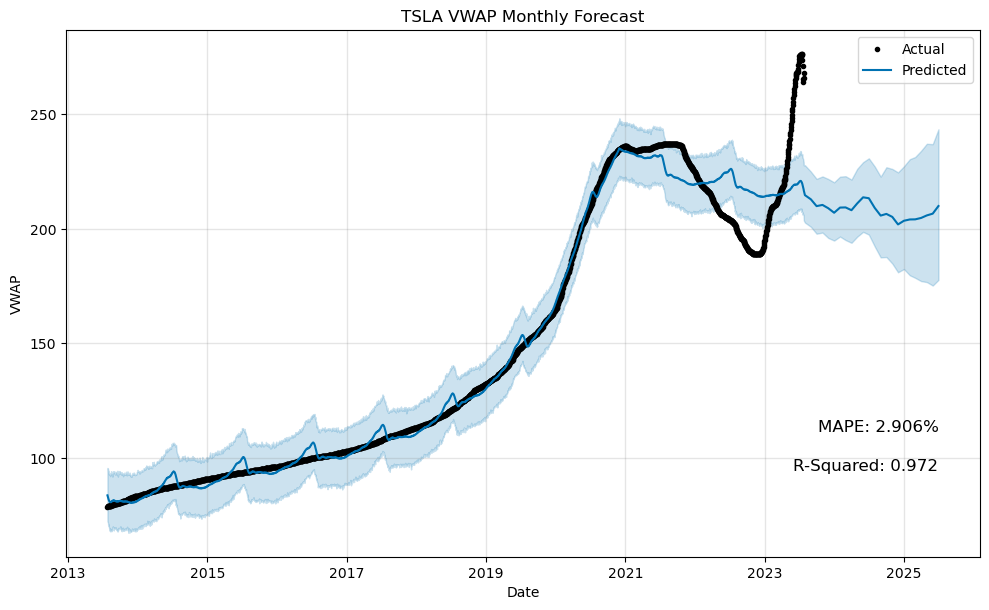

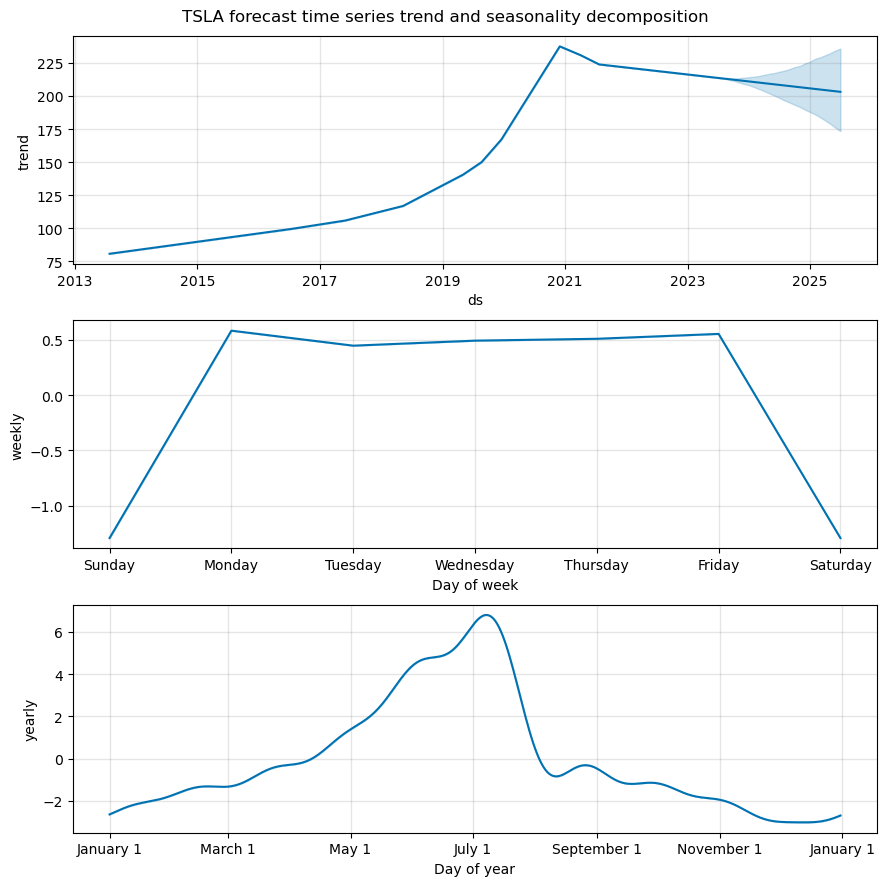

In [83]:
# Forecasting for stock price of TSLA

stock_forecast(tsla_df, stock_symbol="TSLA", periods = 24, freq = 'm')

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)
12:51:07 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing


R-Squared: 0.721
MAPE: 3.864%


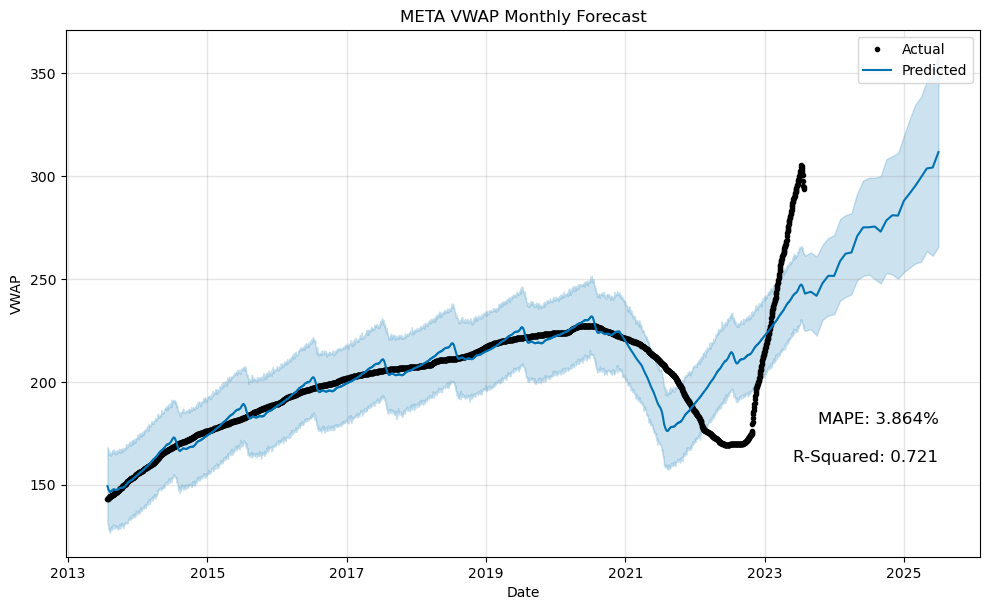

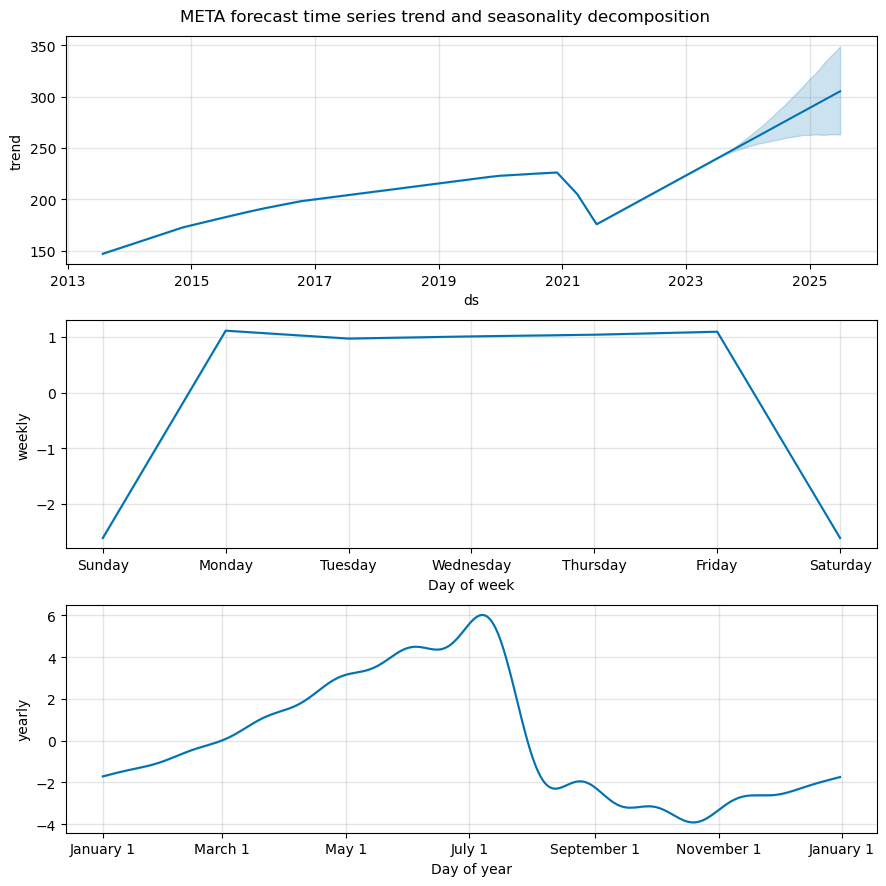

In [84]:
# Forecasting for stock price of META

stock_forecast(meta_df, stock_symbol="META", periods = 24, freq = 'm')

## r/investing stocks

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)
12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:09 - cmdstanpy - INFO - Chain [1] done processing


R-Squared: 0.917
MAPE: 1.050%


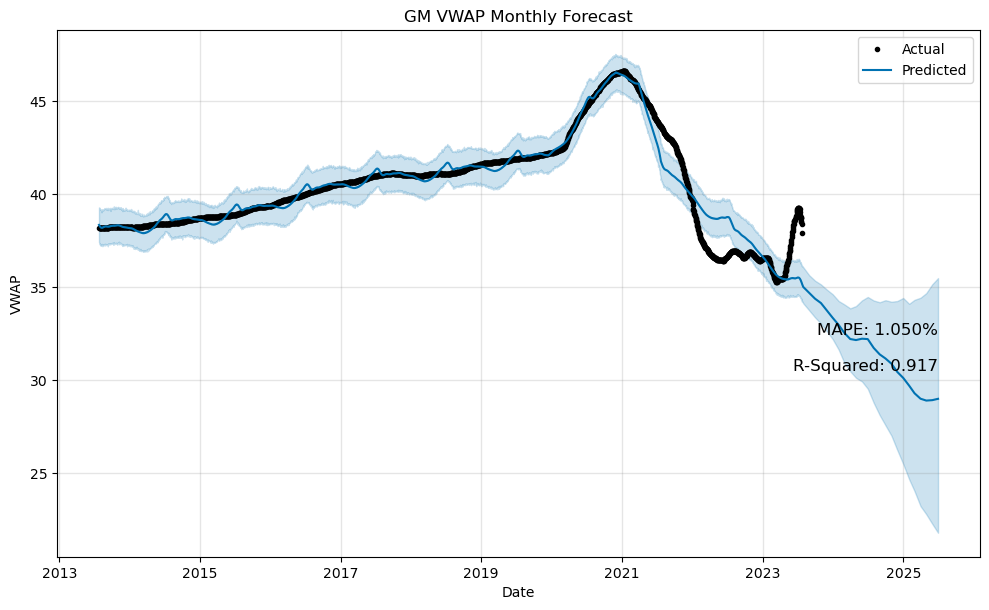

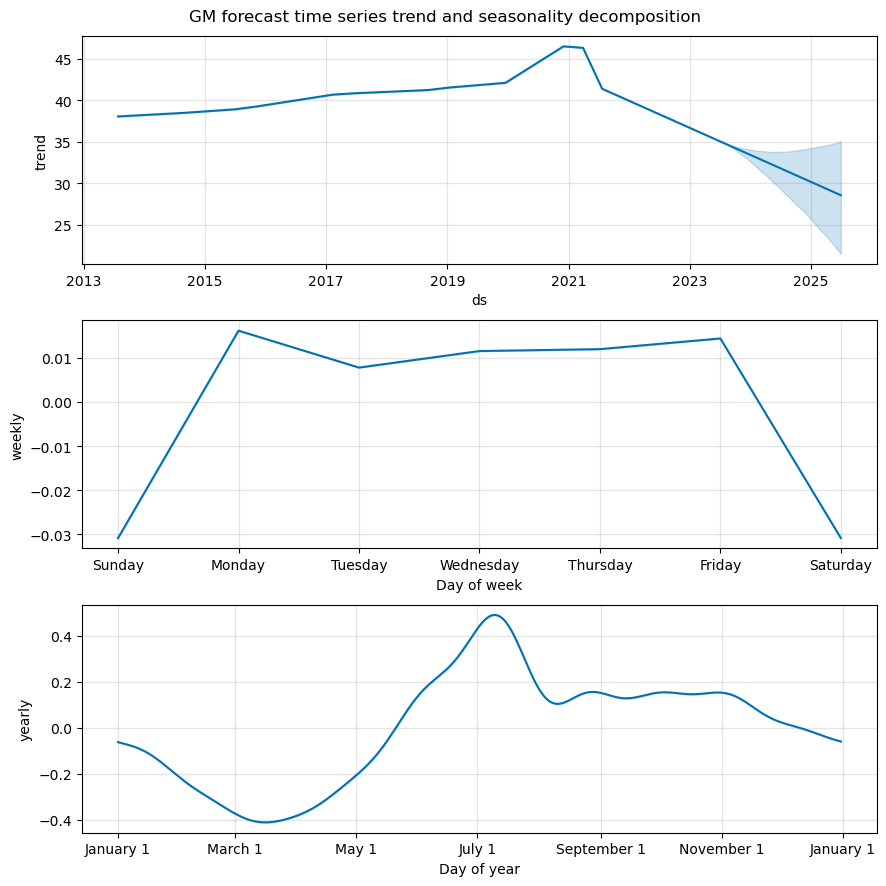

In [85]:
# Forecasting for stock price of GM

stock_forecast(gm_df, stock_symbol="GM", periods = 24, freq = 'm')

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)
12:51:11 - cmdstanpy - INFO - Chain [1] start processing
12:51:11 - cmdstanpy - INFO - Chain [1] done processing


R-Squared: 0.999
MAPE: 0.175%


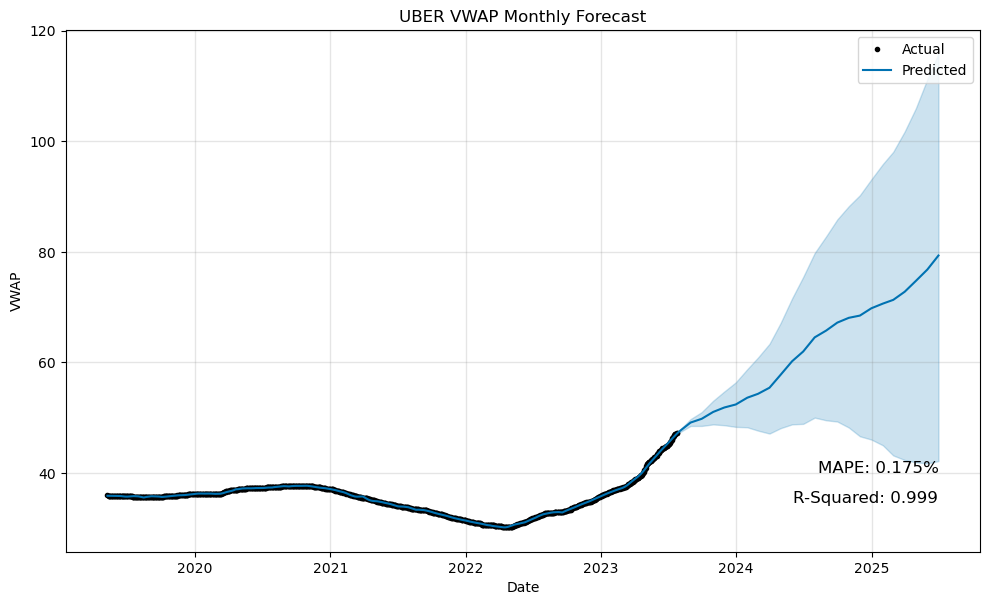

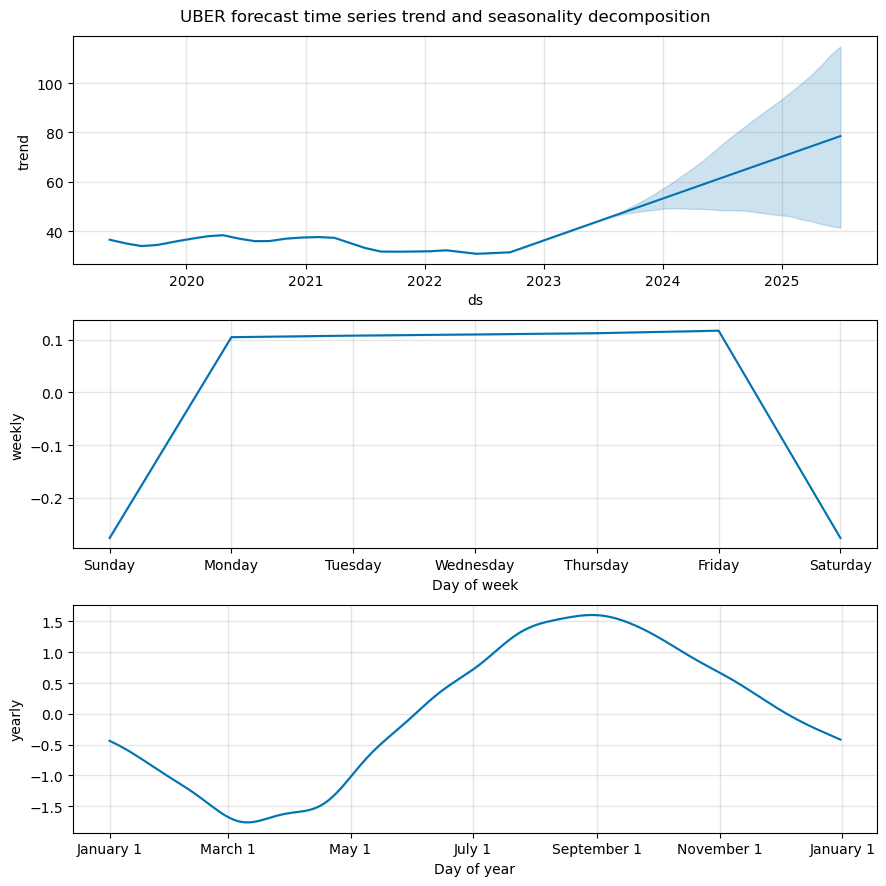

In [86]:
# Forecasting for stock price of UBER

stock_forecast(uber_df, stock_symbol="UBER", periods = 24, freq = 'm')

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)
12:51:12 - cmdstanpy - INFO - Chain [1] start processing
12:51:12 - cmdstanpy - INFO - Chain [1] done processing


R-Squared: 0.900
MAPE: 4.449%


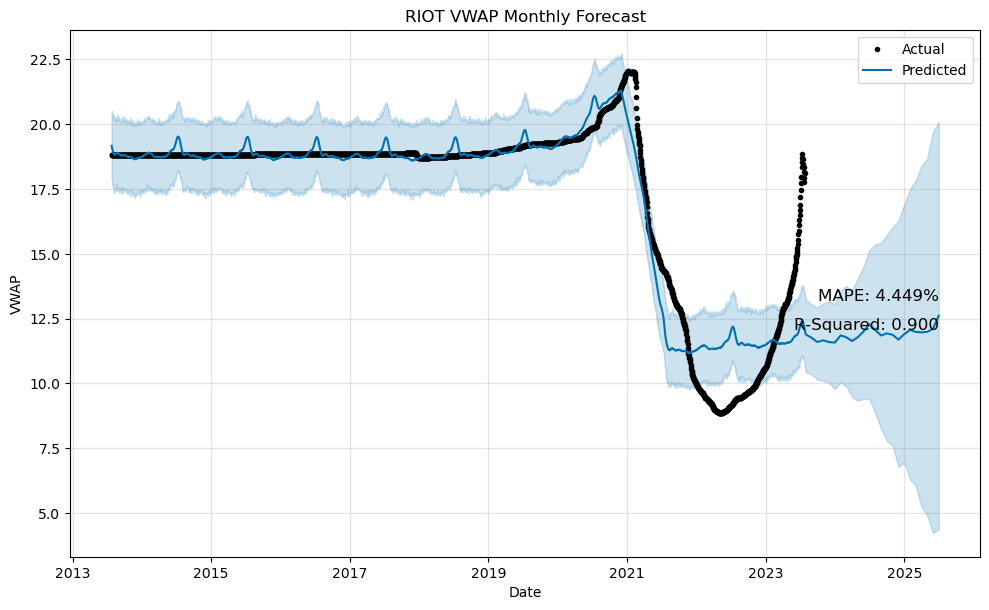

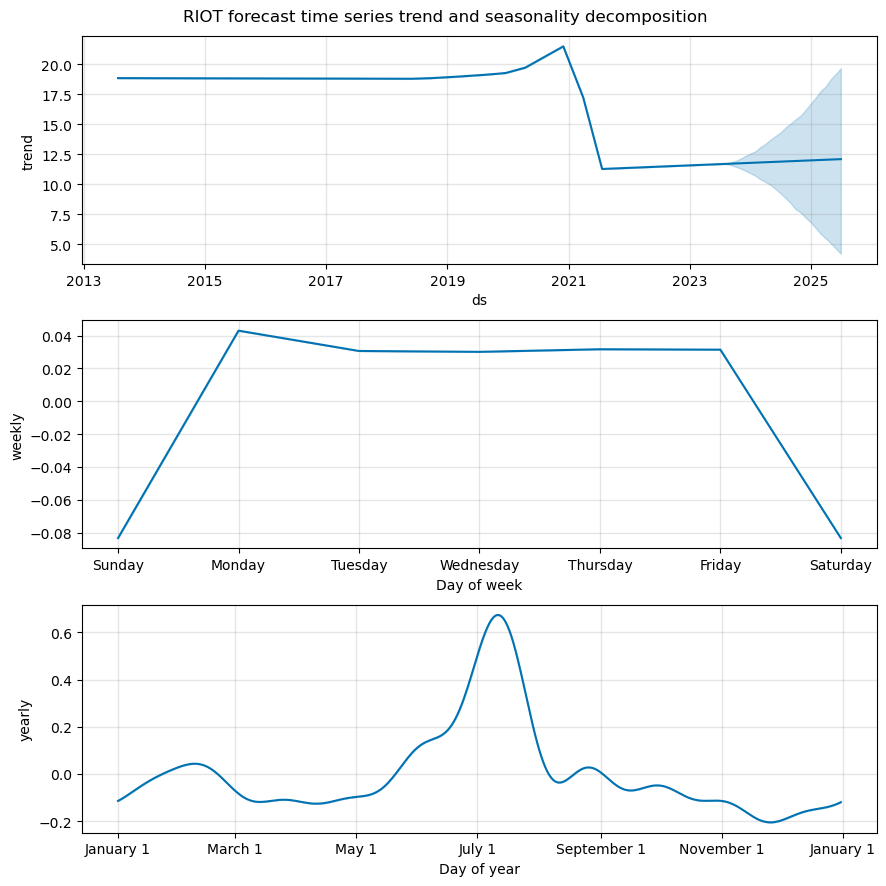

In [87]:
    # Forecasting for stock price of RIOT

stock_forecast(riot_df, stock_symbol="RIOT", periods = 24, freq = 'm')

C:\Users\Admin\AppData\Local\Temp\ipykernel_28732\2671839315.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "").astype(float)
12:51:13 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing


R-Squared: 0.963
MAPE: 2.282%


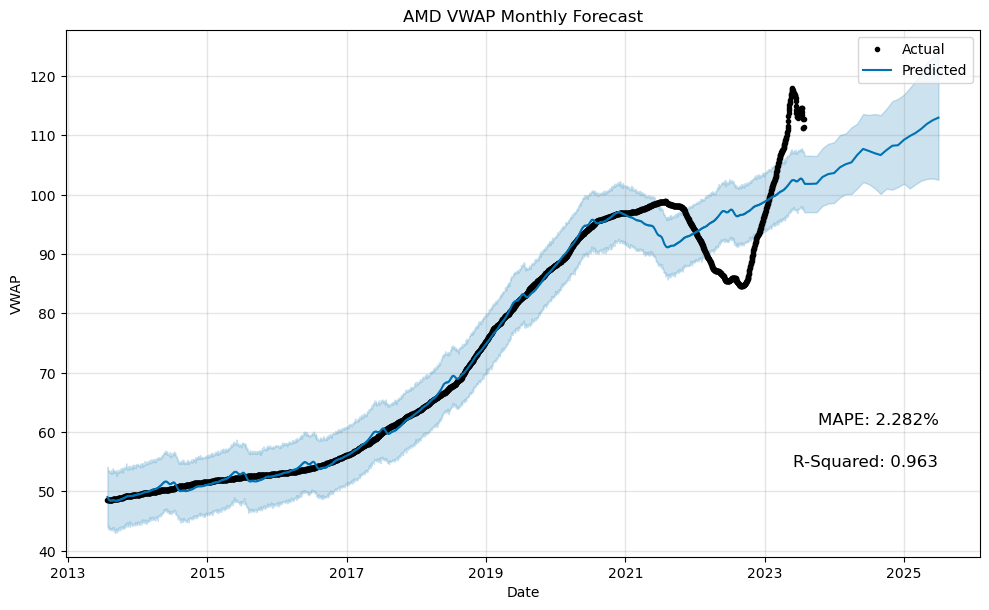

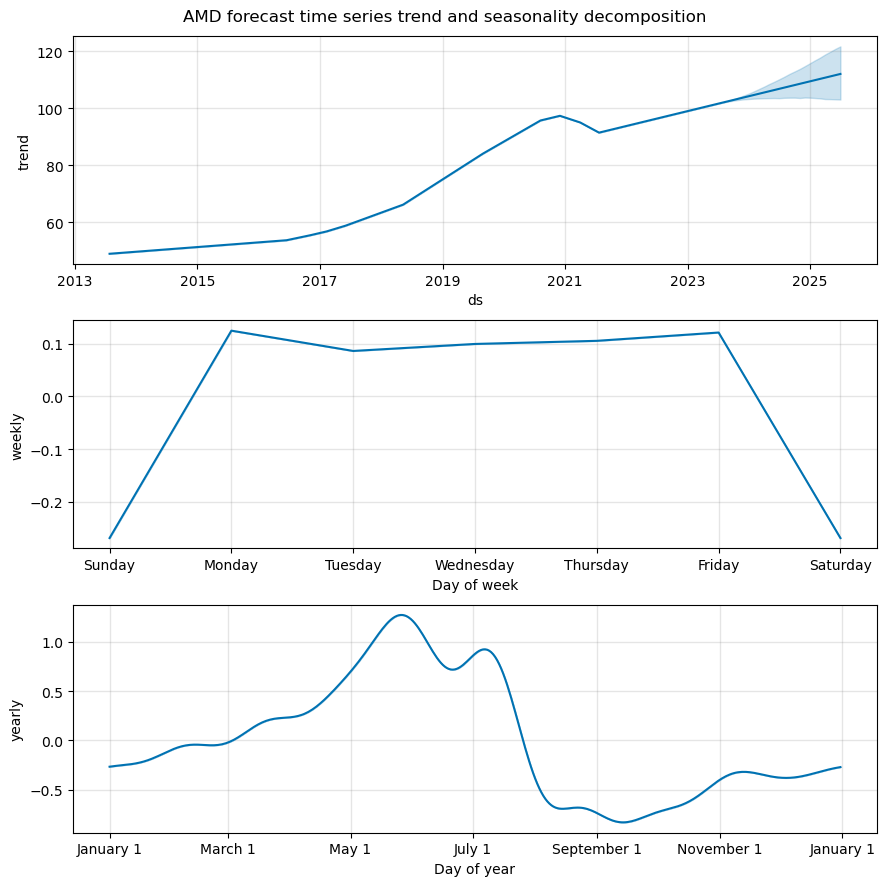

In [88]:
# Forecasting for stock price of AMD

stock_forecast(amd_df, stock_symbol="AMD", periods = 24, freq = 'm')